# Undergraduate Research: mRNA Degradation, Site-specific Pause, Supercoiling, Busty Promoter

# Table of contents<a name="toc"></a>
0. [Table of Content](#toc)
1. [Introduction and Methods](#introduction)
2. [Codes](#code)
    1. [import](#import)
    2. [Parameters](#parameters)
    3. [Helper Functions](#helper)
    4. [Classes](#classes)
        1. [Environment Class](#envi)
        2. [DNAstrand Class](#dna)
        3. [RNAP Class](#rnap)
    5. [TEST](#test)
3. [Simulation](#sim)
4. [Result](#result)


# Introduction and Methods<a name="introduction"></a>
This model concerns with four main aspects of DNA and protein production: Supercoiling, Site-specific Pausing, mRNA degradation, Busty Promoter. <br>


Being object-oriented, there are three classes: [Environment](#envi), [DNAstrand](#dna) and [RNAP](#rnap). <br> 
The [Environment](#envi) class is used to initiate the simulation. It directly control the DNAstrand instance, control the time-stepping of everying.  The Environment class collect, store and return every simulated data from the DNAstrand. <br> 
The [DNAstrand](#dna) class contains all the data including every RNAP instance which is loaded. Upon initiation, it will determine when RNAP loadings will be attempted. Aside from being data package, this class also directly calculate transcription velocity of every RNAP instance.<br>
The [RNAP](#rnap) class is simply individual RNAP. This is of course a data storage for that instance of RNAP and also manages loading of Ribosomes and their translational elongation.<br>
Each of the three classes has a function get_internal(), which just return the a numpy array which contains their internal data. For DNAstrand and RNAP classes, this function only return their internal states at that specific time, when the function is called. But for the Environment class, the function will return data that spanned the whole duration. Logicaly, DNAstrand.get_internal() and RNAP.get_internal() are just helper function to Environment.get_internal().<br>
In general, one only need to use the environment class to conduct a simulation.

Supercoiling is generated through [supercoil_velocity(RNAP_list)](#supercoil) function. The loading list for busty promoter is generated using [promoter_time_list(time_tot, on_time, off_time)](#busty) function. 

# Codes <a name="code"></a>

## Import <a name="paragraph1"></a>

This code utilize both python list and numpy array, though python list is utilized more. 
The numpy random is also used to generate exponential distribution.

In [1]:
import numpy as np
from numpy import random as rand
import random
import scipy
import matplotlib.pyplot as plt
import timeit
import math
import time
import multiprocessing as mp

## Parameters<a name="parameters"></a>

In [2]:
# Environment variable
total_time = 7000 #simulation time second
dt = 1/30 # s
data_collection_interval = 1/2 # second
stage_per_collection = int(data_collection_interval/dt)
data_smoothing_interval = 5 #s 
max_processes_used = 6 #processes

# Basic Coefficients
length = 3072   # Length of lacZ gene or 3075 bps
proteinLL = 1200 #s

# Busty Promoter Coefficient
tau_off= 143 #s 1/k_off
tau_loading = 2.2 #s 1/k_loading
list_interval_loading = [3.5, 7, 15, 30, 500] #s 1/k_on

# Site-Specific Pausing Coefficient
pauseProfile = ("flat", "OnepauseAbs", "TwopauseAbs")
pauseSite = (1500, 2500)
pauseDuration = (10, 15) #s
pauseProb = 0.8

# RNAP Variables
RNAP_size = 35 #bps
k_elong = 30.5
mRNALL = 90 #s Mean mRNA lifetime
proteinLL = 1200 #s


# Ribosome Variables
RIBO_size = 30 #nts
ribo_loading_interval = 500
tau_mRNA = 90 
kRiboLoading = 1/5 #sec^-1
initiation_nt = 33 #nts

# mRNA degradation
list_times_degradation = (7, 15, 30, 60) #s

# Supercoiling Variables
gamma = 0.01 #supercoiling constant
v_0 = 30.5
tau_c = 11
tau_0 = 0.386

# Test
testing = True # This control if testing will be conducted

## Helper Functions<a name="helper"></a>

#### Supercoiling <a name="supercoil"></a>

In [3]:
def S(R):
    return (gamma*R)

def n_dependence_cubic_3(x):
    return 1+0.778753*(x-1)+3.3249*(x-1)**2+0.379478*(x-3)**3

def phi(RNAP_list, detached_rnap_amount):
    size = len(RNAP_list) - detached_rnap_amount
    if size == 0:
        return None
    PHI = np.zeros(size+1)
    
    for i in range(size+1):
        j = i + detached_rnap_amount
        if i == 0:
            PHI[i] = S(RNAP_list[j].position)
            continue
        elif i ==size:
            PHI[i] = S(RNAP_list[j-1].position)
            continue
        else:
            PHI[i] = S(RNAP_list[j-1].position-RNAP_list[j].position)
    
    return PHI

def torque(phi):
    size = np.size(phi)-1
    torq = np.zeros(size)
    n = n_dependence_cubic_3(size)
    for i in range(size):
        torq[i] = -tau_0*n*(phi[i]-phi[i+1])
        
    
    return torq

def velocity(tau, detached_rnap_amount):
    size = np.size(tau) + detached_rnap_amount
    velo = np.zeros(size)
    
    for i in range(detached_rnap_amount):
        velo[i] = 0
        
    for i in range(np.size(tau)):
        j = i + detached_rnap_amount
        if tau[i] > 1.5*tau_c:
            velo[j] = 0
        elif tau[i] < -1.5*tau_c:
            velo[j] = 2* v_0
        else:
            velo[j] = 2*v_0/(1+np.exp(2*(tau[i]/tau_c)**3))
    return velo
    
def supercoil_velocity(RNAP_list):
    detached_rnap_amount = 0
    
    for rnap in RNAP_list:
        if not rnap.attached:
            detached_rnap_amount+=1
    
    if detached_rnap_amount == len(RNAP_list):
        return np.zeros(len(RNAP_list))
    
    PHI = phi(RNAP_list, detached_rnap_amount)
    torq =torque(PHI)
    velo = velocity(torq,detached_rnap_amount)
    return velo


#### RNAP_loading_list

In [4]:
#RNAP_time_list(arr, load_rate) is used to generate loading attempt time.
def RNAP_loading_list(arr, load_rate):
    t_loading = []
    time_last = 0
    for pair in arr:
        if pair[0]:
            loading_list = load_list(pair[1]-time_last, load_rate)
            acc_t = 0
            for t in loading_list:
                t_loading.append(t + time_last + acc_t)
                acc_t += t
        time_last = pair[1]
    #print(len(t_loading))
    # additional normalization is performed to clean any loading attempt that is too close to the other set temporally.
    # so that within one dt, only one attempt is performed. Such attempt would obviously fail.
    elem = 0 
    to_remove = []
    for count, t in enumerate(t_loading):
        if count != 0 and not(t in to_remove):
            if t - elem < dt:
                to_remove.append(t)
            else:
                elem = t
    for item in to_remove:
        t_loading.remove(item)
    
    return t_loading

def RIBO_loading_list(duration, load_rate):
    loading_list = load_list(duration, load_rate)
    t_loading = []
    acc_t = 0
    for t in loading_list:
        t_loading.append(t + acc_t)
        acc_t += t
    return t_loading


def load_list(duration, load_rate):
    ave = 1/ load_rate
    t = 0
    t_slots = []
    
    while t <= duration:
        add_time = rand.exponential(scale = ave)
        if add_time < duration - t:
            t_slots.append(add_time)
            t+=add_time
        else:
            break
    
    return t_slots


#testing
#arr = promoter_time_list(7000,5,3)
#print(arr)
#print(RNAP_loading_list(arr, 1/15))
#print(load_list(20,1/10))
#print(sum(load_list(10,1/10)))
#print(RIBO_loading_list(30, 1/15))

#### promoter_time_list<a name="busty"></a>

In [5]:
#promoter_time_list(float time_tot, float on_time, float off_time)
#This function is used for class DNAstrand initiation. It chucks out a 1-D np array with lists as its elements. 
#Each list represents a time slot with the status of the promoter and the end time of the status. 
#For instance, [True, 13.00], means that the status of the promoter is On, and the status will remain On until 13.00 time_point

#The time is generated following exponential waiting time distribution. 

def promoter_time_list(time_tot, on_time, off_time) :
    t_slots = promoter_time_list_non_cumulative(time_tot, on_time, off_time)
    tot_t = 0;
    for slot in t_slots:
        slot[1] = tot_t + slot[1]
        tot_t = slot[1]
    return t_slots

def promoter_time_list_non_cumulative(time_tot, on_time, off_time) :
    t = 0
    # True indicates a On Promoter. And False indicates an Off Promoter
    i = False # This value here, represent the initial state of the Promoter
    t_slots = []
    while t <= time_tot:
        if i:
            add_time = rand.exponential(scale = off_time)
            if add_time < time_tot - t:
                i = not i
                t_slots.append([False, add_time])
                t+=add_time
            else:
                t_slots.append([False, time_tot - t])
                break
        else:
            add_time = rand.exponential(scale = on_time)
            if add_time < time_tot - t:
                i = not i
                t_slots.append([True, add_time])
                t+=add_time
            else:
                t_slots.append([True, time_tot - t])
                break
    
    return t_slots

#Testing
#arr = promoter_time_list(100,5,3)
#print(arr)

def average_ON_OFF_Time(slots):
    total_ON_t = 0
    total_OFF_t = 0 
    on_n = 0
    off_n = 0
    for slot in slots:
        if slot[0]:
            on_n +=1
            total_ON_t = total_ON_t + slot[1]
        else:
            off_n +=1
            total_OFF_t = total_OFF_t + slot[1]
    return [total_ON_t/on_n, total_OFF_t/off_n, on_n, off_n]

#arr2 = promoter_time_list_non_cumulative(100,5,3)
#print(average_ON_OFF_Time(arr2))

#### Additional Promoter Load Lists

In [6]:
# For this loading list generates a uniform non-busty
def uniform_promoter_time_list(time_tot, on_time, off_time):
    t = 0
    # True indicates a On Promoter. And False indicates an Off Promoter
    i = False # This value here, represent the initial state of the Promoter
    t_slots = []
    while t <= time_tot:
        if i:
            add_time = off_time
            if add_time < time_tot - t:
                i = not i
                t_slots.append([False, add_time])
                t+=add_time
            else:
                t_slots.append([False, time_tot - t])
                break
        else:
            add_time = on_time
            if add_time < time_tot - t:
                i = not i
                t_slots.append([True, add_time])
                t+=add_time
            else:
                t_slots.append([True, time_tot - t])
                break
    tot_t = 0;
    for slot in t_slots:
        slot[1] = tot_t + slot[1]
        tot_t = slot[1]
    return t_slots



#### custom random generator<a name="custom"></a>

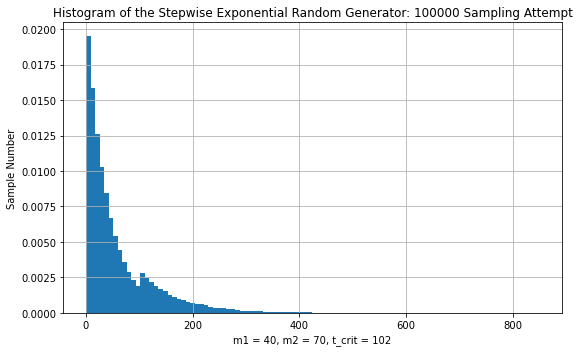

In [16]:
import math
from numpy import random as rand


#this is used for generator two phase step-wise random distribution
def stepwise_exponential_generator(m1, m2, tcrit):
    # portion represents the integral of exponential distribution across its regime.
    portion1 = 1-math.exp(-1*tcrit/m1) # this is really is \int^{t_{crit}}_0 \frac{1}{m_1}\cdot e^{-\frac{x}{m_1}} dx
    portion2 = math.exp(-1*tcrit/m2)   # this is really \int^{inf}_{t_{crit}} \frac{1}{m_2}\cdot e^{-\frac{x}{m_2}} dx
    # we normalize the cumulative probability. (this is required, because rand.choice() will throw error message at us, if the probability vector we gives is not normalized.)
    norm_p1 = portion1/(portion1+portion2) 
    norm_p2 = portion2/(portion1+portion2)
    # use choice() function to randomly select which side of the critical time we will go. choice varibale here is just a flag for the result.
    choice = rand.choice([1,2], p = [norm_p1, norm_p2])
    
    
    if choice == 1:
        passed = False
        while not passed:
            result =rand.exponential(scale = m1)
            if result <= tcrit:
                passed = True
    else:
        passed = False
        while not passed:
            result =rand.exponential(scale = m2)
            if result >= tcrit:
                passed = True
    return result


import numpy as np
import matplotlib.pyplot as plt


mu1 = 40
mu2 = 70
t_crit = 102

sample_number = 100000
# to ensure a decent demonstration of random distribution, we dictate that each bin must have around 1000 sample number for our insterested regions.
# this means the bin number is about sample_number / 1000
bin_number = int(sample_number / 1000)

fig, ax = plt.subplots(1, sharey=True, tight_layout=True, figsize = (8, 5))


sampling = np.zeros(sample_number)
for i in range(sample_number):
    sampling[i] = stepwise_exponential_generator(mu1,mu2, t_crit)
    
ax.hist(sampling, bins = bin_number, density  = True) # We normalized the graph, such that the resulting histogram is essentially a pdf.
ax.set_title(f'Histogram of the Stepwise Exponential Random Generator: {sample_number} Sampling Attempt')
ax.set_xlabel(f'm1 = {mu1}, m2 = {mu2}, t_crit = {t_crit}')
ax.set_ylabel('Sample Number')
ax.grid(True);
fig.patch.set_facecolor('xkcd:white')
fig.savefig(f'Histogram_Stepwise_Exp_Rand_Generator_{sample_number}_Attempt')



## Classes<a name="classes"></a>

#### Environment Class <a name="envi"></a>

Stucture of the internal_data variable:
experiment setting, DNA loading time list, data
data: time, RNAPs, RNAPs position, Ribo position.

Data to record including: New Protein Production Amount. Positions and amount of the RNAPs. Position of Ribosome on each RNAP. 

In [8]:
#The class Environment is used to encapsulate all activities, including initiation of the whole sytem. 
#Responsible for stepping of all variable and class, including t. 
#Also responsible for recording all the data and their output.
class Environment:

    def __init__(self, interval_loading = 500, pause_profile = "flat", degradation_time = 0, include_supercoiling = True, include_busty_promoter = True, mRNA_degradation = True):
        self.t = 0
        self.DNA = DNAstrand(interval_loading, pause_profile, degradation_time = 0, include_supercoiling = True, include_busty_promoter = True, mRNA_degradation = True)
        self.total_prot = 0
        
        self.step_processing_time = np.zeros(int(total_time/data_collection_interval))
        
    def step(self): #Used by start().
        return self.DNA.step(self.t)
        
    
    def start(self):
        self.initialize_data_structure()
        per_stage = int(data_collection_interval/dt)
        for i in range(int(total_time/data_collection_interval)):
            t_i = time.perf_counter()
            for j in range(stage_per_collection):
                
                prot = self.step()
                #record protein production
                self.protein_production[i*per_stage+j] = prot
                
                self.total_prot += prot
                #progress time and stage
                self.t += dt
            t_f = time.perf_counter()
            # recording processing for each stage 
            self.step_processing_time[i] = t_f - t_i
            self.step_record(i)
        pass
    
    # This helper function is created separatedly, because the user might want to do modification prior to using start(). By calling initialize_data_structure() inside the start(), the inconsistency from the modification is avoided.
    def initialize_data_structure(self):
         
        # DNA recording
        self.DNA_loading_list = np.copy(self.DNA.loading_list)
        
        # Protein production amount each stepping
        self.protein_cumulative_amount = np.zeros(int(total_time/data_collection_interval))
        
        # Protein production amount each stepping
        self.protein_production = np.zeros(int(total_time/dt))
        
        # RNAP amount
        self.RNAP_amount = np.zeros(int(total_time/data_collection_interval))
        
        # RNAP position
        self.RNAP_position = np.zeros((int(total_time/data_collection_interval), len(self.DNA.loading_list)))
            
        #record the Ribosome Position on the RNA that is produced from the first Ribosome.
        self.DNA_detached_time = np.zeros(len(self.DNA.loading_list))

    
    # Check and record data every step time as defined in the parameter. This step time is different from dt. 
    def step_record(self, index):
        
        #collect the protein amount
        self.protein_cumulative_amount[index] = self.total_prot
        
        #collect the rnap amount
        self.RNAP_amount[index] = len(self.DNA.RNAP_LIST)
        
        #collect the rnap positions
        for i in range(len(self.DNA.RNAP_LIST)):
            self.RNAP_position[index][i] = self.DNA.RNAP_LIST[i].position
    
    # Used for obtaining the inner store data. No need for this now, as all data are exposed.
    def get_internal(self):
        pass
    
    # Find the start index and end index of each RNAP
    # Data is outputed in the format of ((start_index, end_index, if_has_loaded, if_has_detached), (..., ..., ..., ...) ...)
    # Used as helper function by other functions.
    def find_start_end(self):
        start_end = np.zeros((self.RNAP_position.shape[1], 4))
        
        for i in range(self.RNAP_position.shape[1]):
            start = 0
            end = self.RNAP_position.shape[0]
            has_started = False
            has_ended = False
            for j in range(self.RNAP_position.shape[0]):
                if not has_ended: # the RNAP has not yet detacheded
                    if not has_started: # the RNAP has not attached
                        if not self.RNAP_position[j,i] == 0.0: # Check for attachment
                            # once the RNAP has attached, we set the flag has_started to true, so that this condition won't be rechecked. 
                            has_started = True
                            start = j 
                    else: # the RNAP has started
                        if self.RNAP_position[j,i] > length: #The clear sign of detachment of RNAP
                            has_ended = True
                            end = j
                            break
                else: 
                    continue
            start_end[i] = [start, end, has_started, has_ended]
        return start_end
        
    # plotting the trajectory of each RNAP on the axe object provided.
    # each trajectory is ploted individually for cleaness
    def plot_trajectory_RNAP(self, ax):
        final = self.RNAP_position.shape[0]
        #construct time vec
        time = np.arange(0.0, total_time, data_collection_interval)
        start_end = self.find_start_end()
        
        #plot each line vec
        for j in range(self.RNAP_position.shape[1]):
            start = 0
            end = 0
            
            if start_end[j, 2]: # check for start
                start = int(start_end[j, 0])
            else:
                continue
                
            if start_end[j, 3]: # check for end
                end = int(start_end[j,1])
            else:
                end = int(final)
            ax.plot(time[start: end], self.RNAP_position[start:end, j])
        return ax
    
    # Helper function to get_velocity_not_cleaned()
    # result is not cleaned.
    def get_velocity_not_cleaned(self):
        velocity = np.zeros(self.RNAP_position.shape)

        for i in range(self.RNAP_position.shape[0]-1):
            for j in range(self.RNAP_position.shape[1]):
                velocity[i,j] = (self.RNAP_position[i, j] - self.RNAP_position[i-1, j])/data_collection_interval
        
        return velocity
    
    
    # As the name say, this input the axes object from the Matplotlib and plot the velocity graph on that graph. return the axes
    # plotting the velocity of each RNAP on the axe object provided.
    # velocity graph of each RNAP is plotted separately 
    def plot_velocity_RNAP(self, axe, plotting_range = [0, -1]):
        
        
        if plotting_range[1] == -1:
            plotting_range[1] = self.RNAP_position.shape[1]
        
        veloctity_uc = self.get_velocity_not_cleaned()
        time = np.arange(0.0, total_time, data_collection_interval)
        start_end = self.find_start_end()
        final = self.RNAP_position.shape[0]
        
        
        #plot each line vec
        for j in range(plotting_range[0], plotting_range[1]):
            start = 0
            end = 0
            
            if start_end[j, 2]: # check for start
                start = int(start_end[j, 0])
            else:
                continue
                
            if start_end[j, 3]: # check for end
                end = int(start_end[j,1])
            else:
                end = int(final)
            ax.plot(time[start: end], veloctity_uc[start:end, j])
        return ax
    
    def plot_protein_production_per_second(self, ax):
        protein_ps = np.zeros(int(total_time))
        tot_index = self.protein_production.shape[0]
        n = int(1/dt)
        for i in range(int(tot_index/n)):
            ps = 0
            for j in range(n):
                ps+=self.protein_production[i*n+j]
            protein_ps[i] = ps
        #print all the stuff.
        
        ax.plot(range(int(total_time)), protein_ps)
        return ax

Pipeline for Calculating each velocity for RNAP:
1. A velocity array is calculated using supercoiling function. If Supercoiling is not on, then an array of the same v0 velocity is return.
2. Then site-specific pausing is check. the site is the one base-pair interval (x-pause-1, x_pause). So technically, the last bp cannot be the pasuing site, but that poses minimal impact to the simulation. 
3. Now stepping for each RNAP is calcualted, by just timing dt.
4. Hindrance is check and the stepping is moddfied to prevent such things. =>
5. The stepping is then passed to each RNAP instance through step(stepping) function, which will modify its internal data and chew out protein production.

#### DNAstrand Class <a name="dna"></a>

In [9]:
#DNAstrand class handle the supercoiling, RNAP site-specific pausing and RNAP-to-RNAP hindrance and assign degradation coefficient to mRNA instance. 
#RNAP class handle the ribosome progression and act as a data container for RNAP-specific stuffs.
class DNAstrand:
     
    def __init__(self, interval_loading, pause_profile = "flat", degradation_time = 0, include_supercoiling = True, include_busty_promoter = True, mRNA_degradation = True): 
        self.length = length #? not really necessary, but antway
        
        # Supercoiling 
        self.include_supercoiling = include_supercoiling
        
        # Busty Promoter
        if include_busty_promoter:
            tau_on = tau_off * tau_loading/(interval_loading - tau_loading)
            self.promoter_list = promoter_time_list(total_time, tau_on, tau_off)
            self.loading_list = RNAP_loading_list(self.promoter_list, 1/tau_loading)
        else:
            self.loading_list = RNAP_loading_list([[True, total_time]], 1/interval_loading)    

        # Site-Specific Pausing
        self.pause_profile = pause_profile
        self.include_site_specific_pausing = True
        if pause_profile == pauseProfile[0]:
            self.include_site_specific_pausing = False
            self.n_pause = 0
        elif pause_profile == pauseProfile[1]:
            self.n_pause = 1
        elif pause_profile == pauseProfile[2]:
            self.n_pause = 2
        
        # mRNA Degradation
        self.mRNA_degradation = mRNA_degradation
        self.t_degrade = degradation_time
        self.RNAP_LIST = []
        
    def step(self, t):
        
        # calculate supercoiling
        if self.include_supercoiling:
            velo = supercoil_velocity(self.RNAP_LIST)
        else:
            velo = []
            for i in range(len(self.RNAP_LIST)):
                velo.append(v_0)
        
        # check for site-specific pausing and set pausing.
        if self.include_site_specific_pausing and len(self.RNAP_LIST) != 0: 
            for count, rnap in enumerate(self.RNAP_LIST):
                if rnap.passed_site_1 and rnap.passed_site_2:
                    continue
                
                if not rnap.passed_site_1:
                    #check if the the rnap is still in the pause site.
                    if rnap.passing_1 and rnap.position +  1/pauseDuration[0] < pauseSite[0]:
                        velo[count] = 1/pauseDuration[0]
                        continue
                        
                    # passing out of the pausing site.
                    if rnap.passing_1 and rnap.position + 1/pauseDuration[0] >= pauseSite[0]:
                        self.RNAP_LIST[count].passing_1 = False
                        self.RNAP_LIST[count].passed_site_1 = True
                        continue
                        
                    #passing into the pause_site 1
                    if rnap.position < (pauseSite[0] - 1) and ((rnap.position + dt* velo[count]) >=  pauseSite[0] - 1):
                        self.RNAP_LIST[count].passing_1 = True 
                        self.RNAP_LIST[count].position = pauseSite[0] - 1
                        velo[count] = 0
                        #print("Enter Pause Site 1")
                        continue
                
                if not rnap.passed_site_2:
                    if rnap.passing_2 and rnap.position +  1/pauseDuration[1] < pauseSite[1]:
                        velo[count] = 1/pauseDuration[1]
                        continue
                        
                    # passing out of the pausing site.
                    if rnap.passing_2 and rnap.position + 1/pauseDuration[1] >= pauseSite[1]:
                        self.RNAP_LIST[count].passing_2 = False
                        self.RNAP_LIST[count].passed_site_2 = True
                        continue
                        
                    #passing into the pause_site 2
                    if rnap.position < (pauseSite[1] - 1) and ((rnap.position + dt* velo[count]) >=  pauseSite[1] - 1):
                        self.RNAP_LIST[count].passing_2 = True 
                        self.RNAP_LIST[count].position = pauseSite[1] - 1
                        velo[count] = 0
                        continue
                        
        
        # calculate the stepping
        stepping = []
        for velocity in velo:
            stepping.append(velocity*dt)
        
        # check for hindrance and modify stepping
        for count, rnap in enumerate(self.RNAP_LIST):
            if count == 0:
                continue
            if not rnap.attached:
                continue
            else:
                if (rnap.position + stepping[count]) > (self.RNAP_LIST[count-1].position + stepping[count-1]-RNAP_size):
                    stepping[count] = self.RNAP_LIST[count-1].position + stepping[count-1]-RNAP_size - rnap.position
            
        
        # plug the steppings into the RNAPs and collect protein production from all RNAP.
        # implement Multiprocessing here!
        # 6 processes at once in max. 
        prot = 0
        
                
        
        for i in range(len(self.RNAP_LIST)):
            prot += self.RNAP_LIST[i].step(t, stepping[i])

        
        # time to check for loading
        to_load = False
        
        # check if there is one loading attempt
        if len(self.loading_list)!= 0 and t+dt >= self.loading_list[0]:
            to_load = True
                                                       
        # check if there is one RNAP congesting the loading site
        if to_load and len(self.RNAP_LIST) != 0:
            if (self.RNAP_LIST[-1].position - RNAP_size) < 0:
                to_load = False
        
        # if can load, then load one RNAP
        if to_load:
            self.RNAP_LIST.append(RNAP(t+dt, pause_profile = self.pause_profile,  mRNA_degradation = self.mRNA_degradation))
            self.loading_list.pop(0)
        
        
        # return protein production
        return prot
    
    def RNAP_velocity(self):
        return None
    
    def get_internal(self):
        return self.promoter_list
    


#### RNAP Class <a name="rnap"></a>

In [10]:
class RNAP:
    def __init__(self, t, pause_profile = "flat", mRNA_degradation = True):
        #print("loaded")
        self.initial_t = t # means the initial time when the RNAP attached
        self.position = 0 # means position =>
        self.initiated = False # initiated indicates if the length has passed the size required for initiation (33nts)
        self.attached = True # indicated if the RNAP is attached to the DNA. Will detached if reach the end
        
        
        # site-pausing
        self.passed_site_1 = False # passed_site_1 is indicateing whether the RNAP has passed the pausing site. Also used to simply by-pass
        self.passed_site_2 = False
        self.passing_1 = False # if the RNAP is passing 1 or 2.
        self.passing_2 = False
        if pause_profile == pauseProfile[0]:
            self.passed_site_1 = True
            self.passed_site_2 = True
        elif pause_profile == pauseProfile[1]:
            self.passed_site_1 = rand.choice(a = [True, False], p = [1-pauseProb, pauseProb])
            self.passed_site_2 = True
        elif pause_profile == pauseProfile[2]:
            self.passed_site_1 = rand.choice(a = [True, False], p = [1-pauseProb, pauseProb])
            self.passed_site_2 = rand.choice(a = [True, False], p = [1-pauseProb, pauseProb])

        # mRNA degradation
        self.mRNA_degradation =  mRNA_degradation
        self.degraded_length = 0
        self.degrading = False
        if mRNA_degradation:
            self.t_degrade = rand.exponential(scale = ribo_loading_interval)
        else: 
            self.t_degrade = total_time             
        
        # Loading of Ribosomes
        self.loading_list = RIBO_loading_list(self.t_degrade, kRiboLoading)
        self.loading_stage = 0 # tracks which index of loading list to check next.
        self.loading_number = len(self.loading_list)  # how many loading events are there in the loading_list.
        self.RIBO_LIST = np.zeros(self.loading_number) # contains positions of all Ribosomes. 
        self.RIBO_loaded = 0 # shows how many ribosomes are loaded onto the mRNA
        self.RIBO_detached = 0 # shows how many ribomes has detached. 
        
    #RNAP.step() take in the base pair this instance transverse and change its inner data accordingly.
    def step(self, t, pace):
        
        prot = 0
        
        #check if detached
        if self.attached and (self.position + pace >= length):
            self.attached = False
            self.position = length + 1000
            pace = 0
            #print("detached!")
        
        #recalculate(update) degradation
        if not self.degrading: # if the mRNA is not degrading
            if t >= self.t_degrade+ self.initial_t:  # if the time has exceed the degradation time, then the degrading state will be mark True. 
                self.degrading = True
            
            if not self.initiated: # if not marked initiated, then check for if the mRNA has exceed that state. If so, mark the initiated True.
                if self.position + pace >= initiation_nt: 
                    self.initiated = True
                    
            # if the mRNA is initiated, then check for potential Loading.
            if self.loading_stage != self.loading_number and t >= self.initial_t + self.loading_list[self.loading_stage]: # first check if the loading list has been exhausted, then check for potential loading.
                self.loading_stage+=1 # increment the loading state counter. 
                if self.initiated:
                    if self.RIBO_loaded == 0: # if there are zero Ribosome loaded, then no worry for hindrance, just load it. 
                        self.RIBO_loaded += 1
                    else:
                        if self.RIBO_LIST[self.RIBO_loaded-1] - RIBO_size >0: # check for hindrance. 
                            self.RIBO_loaded +=1
                
                
        #set up stepping for Ribosome and check for hindrance
        active_RIBO = self.RIBO_loaded-self.RIBO_detached
        stepping = np.zeros(active_RIBO)
        for i in range(active_RIBO):
            stepping[i]=v_0*dt 
        
        #check for ribo hindrance and the potential ribosome crowding near the end if the mRNA is not detached.
        for i in range(active_RIBO):
            actual_i = i+self.RIBO_detached
            #check for ribo hindrance, with two potential case of hindrance:
            #1. if the mRNA has not finished transcription, then the leading Ribosome cannot move ahead of that length transcribed, as that would be unphysical 
            if i == 0 and self.attached:
                if self.RIBO_LIST[actual_i] + stepping[i] > self.position:
                    stepping[i] = self.position -self.RIBO_LIST[actual_i]
            #2. hindrance between the adjacent Ribosomes
            if i != 0:
                if self.RIBO_LIST[actual_i] + stepping[i] > self.RIBO_LIST[actual_i-1] + stepping[i-1] - RIBO_size:
                    stepping[i] = self.RIBO_LIST[actual_i-1] + stepping[i-1] - RIBO_size - self.RIBO_LIST[actual_i]
        
        #update ribosome position and check for protein production and detached Ribosome
        old_RIBO_detached = self.RIBO_detached
        for i in range(active_RIBO):
            actual_i = i+old_RIBO_detached
            self.RIBO_LIST[actual_i] += stepping[i]
            if self.RIBO_LIST[actual_i] >= length:
                self.RIBO_detached += 1
                prot += 1
        

        # now add pace
        self.position+= pace
        
        #return protein production
        return prot
    
    # return internal data
    def get_internal(self):
        pass

In [11]:
def print_rnap(rnap):
    print("RNAP Loading List:")
    print(rnap1.loading_list)
    print("Degradation Time: " + str(rnap1.t_degrade))
    print("-------------------------")

rnap1= RNAP(0)
print_rnap(rnap1)

t=0
prot = 0
for i in range(total_time*30):
    prot += rnap1.step(t, 0.3)
    t += 1/30
print(rnap1.RIBO_LIST)
print(prot)
print(t)

RNAP Loading List:
[3.76034147157658, 9.594540785952745, 27.883562716480224, 32.398848064504406, 36.06854659584009, 36.47439296943489, 39.184755563296484, 41.09296738835592, 53.735588881100895, 53.944103738436404, 54.02086669318041, 55.94198346618147, 58.547518415076844, 60.93998068972647]
Degradation Time: 62.217253365673315
-------------------------
[3072.41666667 3072.91666667 3072.4        3072.9        3072.38333333
 3072.88333333 3072.36666667 3072.86666667 3072.35       3072.85
 3072.33333333    0.            0.            0.        ]
11
7000.000000033909


# Simulation <a name="sim"></a>

In [12]:
start_time = time.perf_counter()
env = Environment(30, pause_profile = "flat")
env.DNA.loading_list = RNAP_loading_list(uniform_promoter_time_list(total_time, 50, 500), 1/tau_loading)
env.start()
end_time = time.perf_counter()
print(f"Program finished in {end_time-start_time} seconds")

Program finished in 185.2505022 seconds


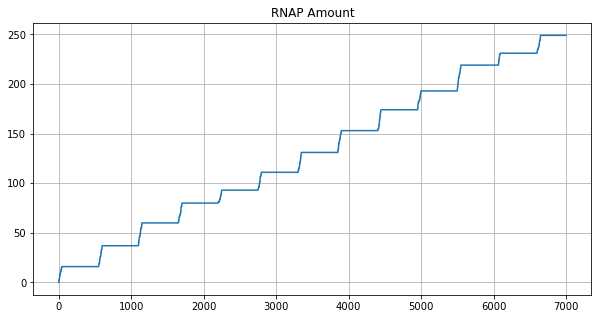

In [13]:
time = np.arange(0.0, total_time, data_collection_interval)
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
ax.set_title('RNAP Amount')
ax.plot(time, env.RNAP_amount)
ax.grid(True)
fig.savefig('rnap_amount.png')

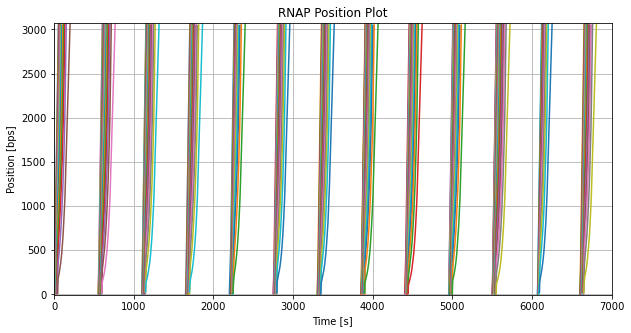

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
fig.patch.set_facecolor('xkcd:white')
env.plot_trajectory_RNAP(ax)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Position [bps]')
ax.set_title('RNAP Position Plot')
ax.axis([-5,total_time, -5, length])
ax.grid(True);
fig.savefig('position.png')

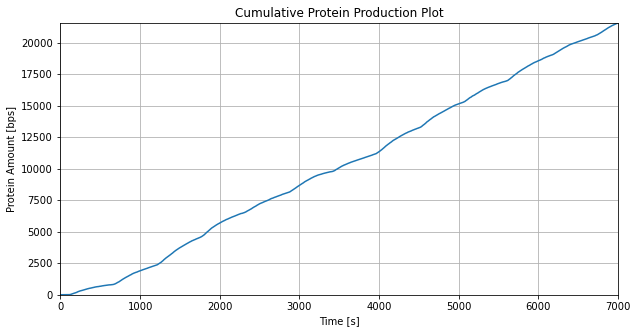

In [15]:
fig, ax = plt.subplots(figsize = (10, 5))
time = np.arange(0.0, total_time, data_collection_interval)
ax.plot(time, env.protein_cumulative_amount)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Protein Amount [bps]')
ax.set_title('Cumulative Protein Production Plot')
ax.axis([-5, total_time, -5, env.protein_cumulative_amount[-1]+10])
ax.grid(True);
fig.savefig('protein_amount.png')

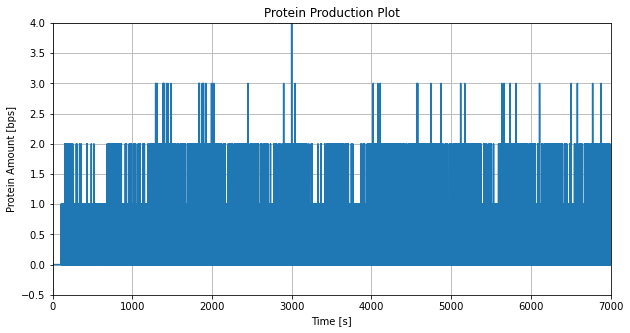

In [16]:
fig, ax = plt.subplots(figsize = (10, 5))
time = np.arange(0.0, total_time, dt)
ax.plot(time, env.protein_production)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Protein Amount [bps]')
ax.set_title('Protein Production Plot')
ax.axis([0, total_time, -0.5, 4])
ax.grid(True);
fig.savefig('protein_production.png')

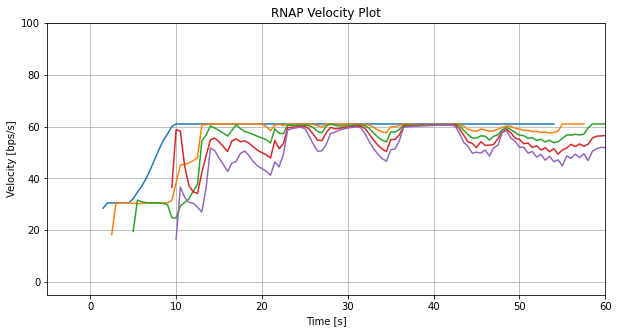

In [17]:
fig, ax = plt.subplots(figsize = (10, 5))
fig.patch.set_facecolor('xkcd:white')

env.plot_velocity_RNAP(ax, plotting_range= [0, 5])

ax.set_xlabel('Time [s]')
ax.set_ylabel('Velocity [bps/s]')
ax.set_title('RNAP Velocity Plot')
ax.axis([-5, 60, -5, 100])
ax.grid(True);
fig.savefig('velocity.png')

In [18]:
env.RNAP_position.shape

(14000, 249)

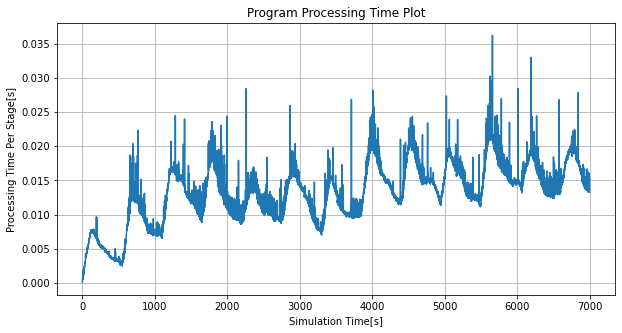

In [19]:
fig, ax = plt.subplots(figsize = (10, 5))
fig.patch.set_facecolor('xkcd:white')

ax.plot(np.arange(0.0, total_time, data_collection_interval), env.step_processing_time)

ax.set_xlabel('Simulation Time[s]')
ax.set_ylabel('Processing Time Per Stage[s]')
ax.set_title('Program Processing Time Plot')
ax.grid(True);
fig.savefig('processing_time.png')

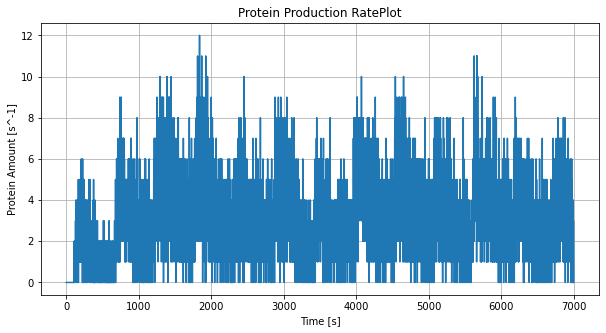

In [20]:
fig, ax = plt.subplots(figsize = (10, 5))
env.plot_protein_production_per_second(ax)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Protein Amount [s^-1]')
ax.set_title('Protein Production RatePlot')

ax.grid(True);
fig.savefig('protein_production_rate.png')

In [21]:
env.protein_production.shape

(210000,)